In [26]:
import os
from IPython.display import Image, display
from uuid import uuid4
from dotenv import load_dotenv

from mem0 import Memory

from langgraph.graph import StateGraph, START, MessagesState, END
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.postgres import PostgresSaver
from psycopg import Connection
from psycopg.rows import dict_row
from langchain_core.messages import SystemMessage

In [2]:
load_dotenv()

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "mem0"

In [4]:
DB_URI = os.getenv("POSTGRES_URI")

In [5]:
HOST = "localhost"

In [6]:
connection_kwargs ={
    "autocommit": True,
    "prepare_threshold": 0,
    "row_factory": dict_row,
}

In [7]:
llm = ChatOpenAI(model="gpt-4o-2024-08-06")

In [8]:
config = {
    "llm": {
        "provider": "openai",
        "config": {
            "model": "gpt-4o-2024-08-06",
            "temperature": 0
        }
    },
    "embedder": {
        "provider": "openai",
        "config": {
            "model": "text-embedding-3-small",
            "embedding_dims": 1536,
        }
    },
    "graph_store": {
        "provider": "neo4j",
        "config": {
            "url":  f"neo4j://{HOST}:{os.getenv('NEO4J_LOCAL_DB_PORT')}",
            "username": os.getenv("NEO4J_USER"),
            "password": os.getenv("NEO4J_PASSWORD")
        }
    },
    "vector_store": {
        "provider": "pgvector",
        "config": {
            "user": os.getenv("POSTGRES_USER"),
            "password": os.getenv("POSTGRES_PASSWORD"),
            "host": HOST,
            "port": os.getenv("POSTGRES_LOCAL_PORT"),
            "dbname": "mem0",
            "embedding_model_dims": 1536,
        }
    },
    "version": "v1.1"
}

In [9]:
mem0 = Memory.from_config(config_dict=config)

In [10]:
class State(MessagesState):
    mem0_user_id: str

In [12]:
def chatbot(state: State):
    messages = state["messages"]
    user_id = state["mem0_user_id"]

    # Retrieve relevant memories
    memories = mem0.search(messages[-1].content, user_id=user_id).get("memories", [])
    print(f"Memories: {memories}")

    context = "Relevant information from previous conversations:\n"
    for memory in memories:
        context += f"- {memory['memory']}\n"

    system_message = SystemMessage(content=f"""You are a helpful customer support assistant. Use the provided context to personalize your responses and remember user preferences and past interactions.
{context}""")

    full_messages = [system_message] + messages
    response = llm.invoke(full_messages)

    # Store the interaction in Mem0
    mem0.add(f"User: {messages[-1].content}\nAssistant: {response.content}", user_id=user_id)
    return {"messages": [response]}

In [13]:
workflow = StateGraph(State)

In [14]:
workflow.add_node("chatbot", chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

In [15]:
conn = Connection.connect(DB_URI, **connection_kwargs)

In [16]:
checkpointer = PostgresSaver(conn)

In [17]:
graph = workflow.compile(checkpointer=checkpointer)

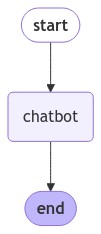

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
mem0_user_id = "customer_tam_1b"

In [22]:
config = {"configurable": {"thread_id": f"{mem0_user_id}-{uuid4()}"}}

In [23]:
user_input = "I am Tam, I like working out. What do you have for me?"
events = graph.stream({"messages": [("user", user_input)], "mem0_user_id": mem0_user_id}, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I am Tam, I like working out. What do you have for me?
Memories: []
================================== Ai Message ==================================

Hi Tam! It's great to hear that you enjoy working out. Here are a few things you might find useful:

1. **Workout Plans**: Depending on your fitness goals, there are various workout plans you can try, like strength training, HIIT, or yoga routines.

2. **Fitness Apps**: Apps like MyFitnessPal, Strava, or Nike Training Club can help track your workouts and progress.

3. **Wearable Tech**: Consider devices like smartwatches or fitness trackers to monitor your activity levels, heart rate, and more.

4. **Nutrition Tips**: Eating the right foods to fuel your workouts is essential. If you're interested, I can provide some general nutrition advice.

5. **Recovery Tools**: Items like foam rollers or massage guns can help with muscle recovery after intense workouts.

In [24]:
config = {"configurable": {"thread_id": f"{mem0_user_id}-{uuid4()}"}}
user_input = "What do i like?"
events = graph.stream({"messages": [("user", user_input)], "mem0_user_id": mem0_user_id}, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What do i like?
Memories: [{'id': 'b497e860-4f64-4765-a52c-0d6ee8449055', 'memory': 'Likes working out', 'hash': 'cd89cc228edaa53de10f29fdf8a035ca', 'metadata': None, 'score': 0.7514338718146566, 'created_at': '2024-09-09T21:30:55.900719-07:00', 'updated_at': None, 'user_id': 'customer_tam_1b'}, {'id': '9a0fb138-c6c4-488f-ba87-a2e7333fd382', 'memory': 'Name is Tam', 'hash': 'e520cfe2b692702ba4dd6342024db729', 'metadata': None, 'score': 0.8666156748900218, 'created_at': '2024-09-09T21:30:55.048811-07:00', 'updated_at': None, 'user_id': 'customer_tam_1b'}]
================================== Ai Message ==================================

You mentioned that you like working out. Is there anything else you'd like to share about your interests?


In [25]:
conn.close()